# UROP

## DESIRE: Distant Future Prediction in Dynamic Scenes with Interacting Agents

[CVPR Paper](https://arxiv.org/pdf/1704.04394.pdf)

[Supplementary Notes](http://www.robots.ox.ac.uk/~namhoon/doc/DESIRE-supp.pdf)

## TODO:

### Sample Generation Module

1) Gradient, i.e. remove straight line/stop (or have some probability of keeping them)

2) Plot with the map (check manual_control.py of CARLA)

### Ranking & Refinement Module

1) Finish implementation

# Table of Contents

1. [Sample Generation Module](#sg_module)
    
    1. [Data](#sg_data)
    
        1. [Load Dataset](#sg_load_dataset)
        
        2. [Get Batch](#sg_get_batch)
    
    2. [Intermediate Models](#sg_intermediate_models)
    
        1. [Encoder](#sg_encoder)
        
        2. [CVAE](#sg_cvae)
        
        3. [FCS](#sg_fcs)
        
        4. [Decoder](#sg_decoder)
    
    3. [Sample Generator Model](#sg_model)
    
    4. [Train](#sg_train)
    
    5. [Visualise](#sg_vis)
    
    6. [Test](#sg_test)
    
2. [Ranking & Refinement Module](#rr_module)

In [1]:
%matplotlib inline

import csv
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

# Sample Generation Module
<a id='sg_module'></a>

## Data
<a id='sg_data'></a>

In [2]:
def print_line_sep():
    print('--------------------------------------')

### Load Dataset
<a id='sg_load_dataset'></a>

In [3]:
def load_dataset(raw_data_path):
    raw_data = []
    with open(raw_data_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        raw_data = list(csvreader)
    print('Raw data extract: ([time, car, x, y, ...])')
    print(raw_data[0])
    print_line_sep()

    filtered_data = [[int(row[0]), int(row[1]), float(row[2]), float(row[3])] for row in raw_data]
    print('Filtered data extract: ([time, car, x, y])')
    print(filtered_data[0])
    print_line_sep()

    car_dict = {}
    for row in filtered_data:
        time = row[0]
        car = row[1]
        x = row[2]
        y = row[3]

        if car in car_dict:
            car_dict[car].append([time, x, y])
        else:
            car_dict[car] = [[time, x, y]]
    print('Car dictionary extract: ([time, x, y])')
    print(car_dict[filtered_data[0][1]][0])
    print_line_sep()

    time_dict = {}
    for row in filtered_data:
        time = row[0]
        car = row[1]
        x = row[2]
        y = row[3]

        if time in time_dict:
            time_dict[time].append([car, x, y])
        else:
            time_dict[time] = [[car, x, y]]
    print('Time dictionary extract: ([car, x, y])')
    print(time_dict[1][0])
    
    data_dict = {'car': car_dict,
                 'time': time_dict}
    
    return data_dict

In [4]:
data_dict = load_dataset('raw_data/raw_record.csv')

Raw data extract: ([time, car, x, y, ...])
['1', '172', '93.939', '-55.7615', '0', '-3.0066', '5.27149', '4', '10']
--------------------------------------
Filtered data extract: ([time, car, x, y])
[1, 172, 93.939, -55.7615]
--------------------------------------
Car dictionary extract: ([time, x, y])
[1, 93.939, -55.7615]
--------------------------------------
Time dictionary extract: ([car, x, y])
[172, 93.939, -55.7615]


### Get Batch
<a id='sg_get_batch'></a>

In [5]:
def get_batch(x_seq_len, y_seq_len, batch_size, data_dict, method='random', remove_stop=False, remove_straight=False, augment_rotate=False, augment_noise=False):
    batch = []
    
    car_dict = data_dict['car']
    time_dict = data_dict['time']
    
    car_dict_keys = list(car_dict.keys())
    
    time_dict_lengths = {time: len(entries) for time, entries in time_dict.items() if len(entries) >= batch_size}
    time_dict_keys = list(time_dict_lengths.keys())
    
    # Fill up batch with batch_size rows of x+y_seq_len columns
    while(len(batch) < batch_size):        
        if method == 'random':
            car = random.choice(car_dict_keys)
            batch_item = []
            is_first_of_sequence = True

            # Loop through each row of that car until x_seq_len+y_seq_len columns are found
            # TODO: randomise which time sequence taken for each car
            for row in car_dict[car]:
                time = row[0]
                x = row[1]
                y = row[2]

                # If first item of the sequence, just append
                if is_first_of_sequence:
                    batch_item.append([time, x, y])
                    is_first_of_sequence = False

                # Else, check if time diff is 1
                else:
                    prev_time = batch_item[-1][0]

                    # If time diff is not 1, clear batch item, and start from current location as first batch item
                    if time - prev_time != 1:
                        batch_item = []
                        batch_item.append([time, x, y])

                    # Else, just append to batch item
                    else:
                        batch_item.append([time, x, y])
                        
                # If batch item columns are enough, break
                if len(batch_item) == x_seq_len + y_seq_len:
                    is_append = True
                    if remove_stop:
                        if np.abs(batch_item[0][1] - batch_item[-1][1]) < 1 and np.abs(batch_item[0][2] - batch_item[-1][2]) < 1:
                            is_append = False
                    
                    if is_append:
                        batch.append(batch_item)
                        break
                    
        elif method == 'sync':
            start_time = random.choice(time_dict_keys)
                        
            # Check if there are batch_size number of cars that stay 
            # from start_time to start_time+x_seq_len+y_seq_len
            for row in time_dict[start_time]:
                if len(batch) == batch_size:
                    break
                
                car = row[0]
                x = row[1]
                y = row[2]
                batch_item = [[car, x, y]]
                    
                for time in range(start_time + 1, start_time + x_seq_len + y_seq_len):
                    for time_row in time_dict[time]:
                        if time_row[0] == car:
                            x = time_row[1]
                            y = time_row[2]
                            batch_item.append([car, x, y])
                            break
                    
                
                if len(batch_item) == x_seq_len + y_seq_len:
                    is_append = True
                    if remove_stop:
                        if np.abs(batch_item[0][1] - batch_item[-1][1]) < 1 and np.abs(batch_item[0][2] - batch_item[-1][2]) < 1:
                            is_append = False
                
                    if is_append:
                        batch.append(batch_item)
                    
            if len(batch) < batch_size:
                batch = []
                
    # Just keep (x,y)  
    X_position_array = [[[item[1], item[2]] for item in batch_item[:x_seq_len]] for batch_item in batch]
    Y_position_array = [[[item[1], item[2]] for item in batch_item[x_seq_len:]] for batch_item in batch]
    
    X_position_np = np.asarray(X_position_array).transpose(0, 2, 1)
    Y_position_np = np.asarray(Y_position_array).transpose(0, 2, 1)
    
    # Augment
    if augment_noise:
        X_noise = np.random.normal(0, 0.1, X_position_np.shape)
        Y_noise = np.random.normal(0, 0.1, Y_position_np.shape)
        
        X_position_np = X_noise + X_position_np
        Y_position_np = Y_noise + Y_position_np
    
    if augment_rotate:
        for i in range(batch_size):
            rotation_radian = random.randint(0, 359)*np.pi/180
            
            X_position_np[i][0] = X_position_np[i][0]*np.cos(rotation_radian) + X_position_np[i][1]*np.sin(rotation_radian)
            X_position_np[i][1] = -X_position_np[i][0]*np.sin(rotation_radian) + X_position_np[i][1]*np.cos(rotation_radian)

            Y_position_np[i][0] = Y_position_np[i][0]*np.cos(rotation_radian) + Y_position_np[i][1]*np.sin(rotation_radian)
            Y_position_np[i][1] = -Y_position_np[i][0]*np.sin(rotation_radian) + Y_position_np[i][1]*np.cos(rotation_radian)

    
    X_position_tensor = torch.from_numpy(X_position_np).type(torch.FloatTensor).cuda()
    Y_position_tensor = torch.from_numpy(Y_position_np).type(torch.FloatTensor).cuda()
    
    # Convert position to displacement
    X_displacement_array = []
    Y_displacement_array = []

    for i in range(batch_size):
        x_first = X_position_array[i][0][0]
        y_first = X_position_array[i][0][1]

        X_batch = X_position_array[i]
        X_displacement_array.append([[item[0] - x_first, item[1] - y_first] for item in X_batch])

        Y_batch = Y_position_array[i]
        Y_displacement_array.append([[item[0] - x_first, item[1] - y_first] for item in Y_batch])

    X_displacement_np = np.asarray(X_displacement_array).transpose(0, 2, 1)    
    Y_displacement_np = np.asarray(Y_displacement_array).transpose(0, 2, 1)
    
    X_displacement_tensor = torch.from_numpy(X_displacement_np).type(torch.FloatTensor).cuda()
    Y_displacement_tensor = torch.from_numpy(Y_displacement_np).type(torch.FloatTensor).cuda()
    
    return X_position_tensor, Y_position_tensor, X_displacement_tensor, Y_displacement_tensor

In [6]:
def visualise_trajectories(X_true, Y_true, batch_size, Y_hats=None):
    # Plot all trajectories of the batch
    traj_fig = plt.figure(figsize=(20, 20))
    traj_fig.tight_layout()        
    for i in range(batch_size):
        ax = traj_fig.add_subplot(batch_size/2, batch_size/2, i + 1)

        ax.plot(X_true[i][0].cpu().detach().numpy(),
                X_true[i][1].cpu().detach().numpy(),
                linestyle='-', marker='o', color='y', label='Past')

        ax.plot(Y_true[i][0].cpu().detach().numpy(),
                Y_true[i][1].cpu().detach().numpy(),
                linestyle='-', marker='o', color='b', label='True')
        
        if Y_hats is not None:
            for j in range(len(Y_hats)):
                Y_hat = Y_hats[j]

                if j == 0:
                    ax.plot(Y_hat[i][0].cpu().detach().numpy(),
                            Y_hat[i][1].cpu().detach().numpy(),
                            linestyle='-', marker='o', color='r', label='Reconstructed')
                else:
                    ax.plot(Y_hat[i][0].cpu().detach().numpy(),
                            Y_hat[i][1].cpu().detach().numpy(),
                            linestyle='-', marker='o', color='r')

        if i == 0:
            ax.legend(loc='upper left')
            ax.set_xlabel('x-coordinate')
            ax.set_ylabel('y-coordinate')

        X_true_x_min = X_true[i][0].cpu().detach().numpy().min()
        X_true_x_max = X_true[i][0].cpu().detach().numpy().max()
        X_true_y_min = X_true[i][1].cpu().detach().numpy().min()
        X_true_y_max = X_true[i][1].cpu().detach().numpy().max()
        
        Y_true_x_min = Y_true[i][0].cpu().detach().numpy().min()
        Y_true_x_max = Y_true[i][0].cpu().detach().numpy().max()
        Y_true_y_min = Y_true[i][1].cpu().detach().numpy().min()
        Y_true_y_max = Y_true[i][1].cpu().detach().numpy().max()
        
        Y_hat_x_min = Y_true_x_min
        Y_hat_x_max = Y_true_x_max
        Y_hat_y_min = Y_true_y_min
        Y_hat_y_max = Y_true_y_max
        
        if Y_hats is not None:
            Y_hat_x_min = Y_hats[0][i][0].cpu().detach().numpy().min()
            Y_hat_x_max = Y_hats[0][i][0].cpu().detach().numpy().max()
            Y_hat_y_min = Y_hats[0][i][1].cpu().detach().numpy().min()
            Y_hat_y_max = Y_hats[0][i][1].cpu().detach().numpy().max()
            for j in range(1, len(Y_hats)):        
                Y_hat_x_min = Y_hat_x_min if Y_hat_x_min < Y_hats[j][i][0].cpu().detach().numpy().min() else Y_hats[j][i][0].cpu().detach().numpy().min()
                Y_hat_x_max = Y_hat_x_max if Y_hat_x_max > Y_hats[j][i][0].cpu().detach().numpy().max() else Y_hats[j][i][0].cpu().detach().numpy().max()
                Y_hat_y_min = Y_hat_y_min if Y_hat_y_min < Y_hats[j][i][1].cpu().detach().numpy().min() else Y_hats[j][i][1].cpu().detach().numpy().min()
                Y_hat_y_max = Y_hat_y_max if Y_hat_y_max > Y_hats[j][i][1].cpu().detach().numpy().max() else Y_hats[j][i][1].cpu().detach().numpy().max()

        xy_x_min = np.sort(np.array([X_true_x_min, Y_true_x_min, Y_hat_x_min]), axis=None)[0]
        xy_x_max = np.sort(np.array([X_true_x_max, Y_true_x_max, Y_hat_x_max]), axis=None)[-1]
        xy_y_min = np.sort(np.array([X_true_y_min, Y_true_y_min, Y_hat_y_min]), axis=None)[0]
        xy_y_max = np.sort(np.array([X_true_y_max, Y_true_y_max, Y_hat_y_max]), axis=None)[-1]

        xy_delta = xy_x_max - xy_x_min if xy_x_max - xy_x_min > xy_y_max - xy_y_min else xy_y_max - xy_y_min

        ax.set_xlim(xy_x_min - 10, xy_x_min + xy_delta + 10)
        ax.set_ylim(xy_y_min - 10, xy_y_min + xy_delta + 10)

X positions:
torch.Size([8, 2, 20])
tensor([[ 265.0278,  265.2350,  265.7166,  265.9451,  266.1929,  266.5967,
          266.9760,  267.2722,  267.7742,  268.0488,  268.4368,  268.8526,
          269.1516,  269.5453,  270.1117,  270.4283,  270.8959,  271.1435,
          271.3220,  271.7905],
        [-101.4915, -101.5405, -101.6293, -101.8850, -101.8705, -101.9817,
         -102.3667, -102.3603, -102.3271, -102.7379, -102.9520, -102.8725,
         -103.0080, -103.1865, -103.5719, -103.4508, -103.6866, -103.8169,
         -103.9121, -103.9698]], device='cuda:0')
--------------------------------------
Y positions:
torch.Size([8, 2, 40])
tensor([[ 272.1065,  272.7031,  273.1233,  273.4466,  273.6953,  274.0243,
          274.5063,  274.8928,  274.9475,  275.4206,  275.6966,  276.1259,
          276.3259,  276.8423,  277.3215,  277.5205,  277.8546,  278.3498,
          278.8637,  279.0039,  279.5473,  279.5281,  280.0974,  280.2682,
          280.8515,  281.1487,  281.5997,  282.1886,  282

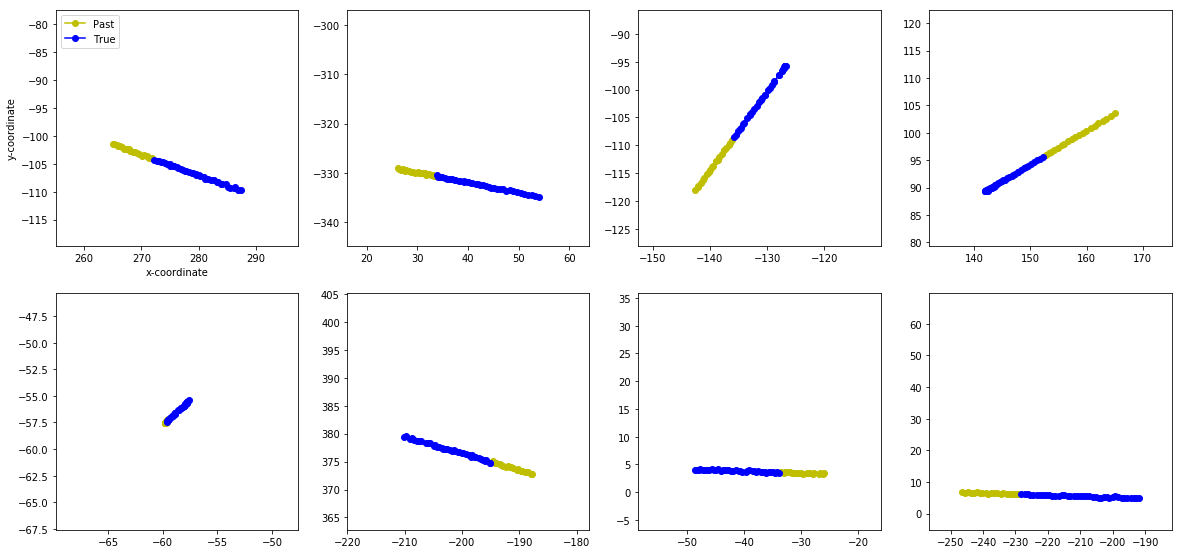

In [7]:
# Test random batch

X_position_test, Y_position_test, X_displacement_test, Y_displacement_test = get_batch(20, 40, 8, data_dict,
                                                                                       remove_stop=True,
                                                                                       augment_noise=True,
                                                                                       augment_rotate=True)

print('X positions:')
print(X_position_test.size())
print(X_position_test[0])

print_line_sep()

print('Y positions:')
print(Y_position_test.size())
print(Y_position_test[0])

print_line_sep()

print('X displacements:')
print(X_displacement_test.size())
print(X_displacement_test[0])

print_line_sep()

print('Y displacements:')
print(Y_displacement_test.size())
print(Y_displacement_test[0])

print_line_sep()

visualise_trajectories(X_position_test, Y_position_test, 8)

X positions:
torch.Size([8, 2, 20])
tensor([[ -6.5768,  -5.9315,  -5.7602,  -5.4012,  -4.7675,  -4.7163,
          -4.4737,  -3.8527,  -3.4852,  -2.9759,  -2.7297,  -2.4312,
          -2.0706,  -1.6905,  -1.3171,  -0.8458,  -0.4886,  -0.0700,
           0.2056,   0.5216],
        [  2.5546,   3.3423,   3.5656,   3.9998,   4.7839,   4.8522,
           5.1555,   5.9098,   6.3609,   7.0008,   7.3065,   7.6617,
           8.1158,   8.5751,   9.0423,   9.6194,  10.0595,  10.5701,
          10.9252,  11.3123]], device='cuda:0')
--------------------------------------
Y positions:
torch.Size([8, 2, 40])
tensor([[  0.9262,   1.6024,   1.9987,   2.4068,   2.4247,   2.8397,
           3.2507,   3.5759,   3.9902,   4.4301,   4.7119,   4.9577,
           5.4510,   5.8588,   6.1789,   6.8165,   7.0631,   7.6862,
           8.0211,   8.1883,   8.9547,   9.1680,   9.7178,   9.9453,
          10.6398,  10.7274,  11.2140,  11.3684,  11.8774,  12.1482,
          12.3748,  12.8032,  12.8889,  13.3008,  13

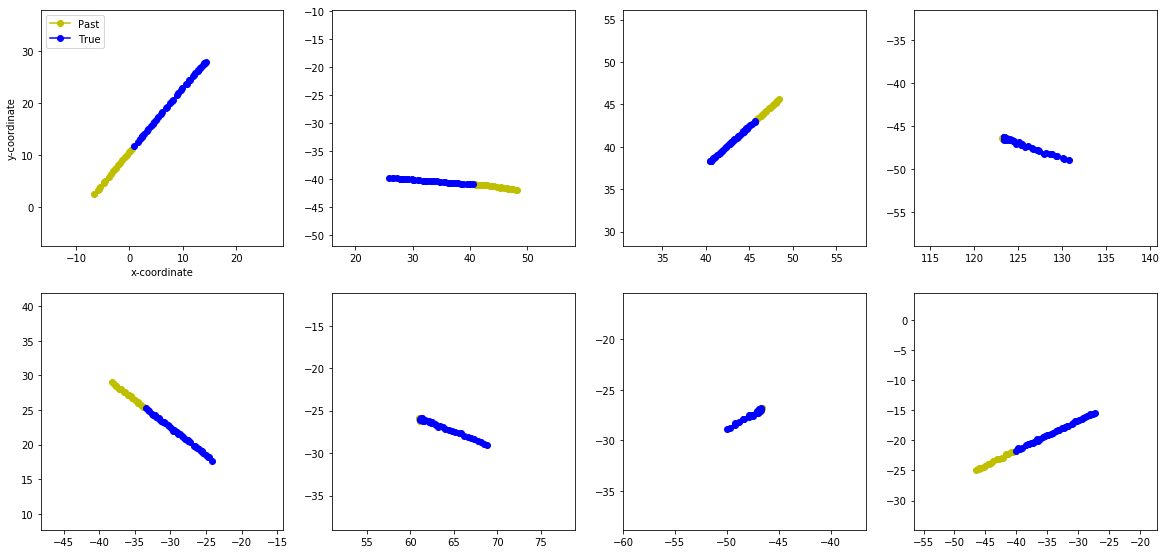

In [8]:
# Test synchronised batch

X_position_test, Y_position_test, X_displacement_test, Y_displacement_test = get_batch(20, 40, 8, data_dict,
                                                                                       method='sync',
                                                                                       remove_stop=True,
                                                                                       augment_noise=True,
                                                                                       augment_rotate=True)

print('X positions:')
print(X_position_test.size())
print(X_position_test[0])

print_line_sep()

print('Y positions:')
print(Y_position_test.size())
print(Y_position_test[0])

print_line_sep()

print('X displacements:')
print(X_displacement_test.size())
print(X_displacement_test[0])

print_line_sep()

print('Y displacements:')
print(Y_displacement_test.size())
print(Y_displacement_test[0])

print_line_sep()

visualise_trajectories(X_position_test, Y_position_test, 8)

## Intermediate Models
<a id='sg_intermediate_models'></a>

### Encoder

<a id='sg_encoder'></a>

In [9]:
class SampleEncoder(nn.Module):
    def __init__(self,
                 input_dim, seq_len, num_layers,
                 conv_output_dim, conv_kernel_size,
                 gru_hidden_dim):
        super(SampleEncoder, self).__init__()
        
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.conv_output_dim = conv_output_dim
        self.conv_kernel_size = conv_kernel_size
        self.gru_hidden_dim = gru_hidden_dim
        
        # C = X or Y
        # C_i, (input_dim, seq_len) -> tC_i, (conv_output_dim, seq_len)
        self.conv = nn.Conv1d(input_dim, conv_output_dim, conv_kernel_size)

        # tC_i, (conv_output_dim, seq_len) -> H_C_i, (gru_hidden_dim)
        self.gru = nn.GRU(conv_output_dim, gru_hidden_dim, num_layers)

    def init_hidden(self, batch_size):
        # Initial hidden vector is hidden_dim-dimensional and padded with 0
        return Variable(torch.zeros(self.num_layers, batch_size, self.gru_hidden_dim)).cuda()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        conv_output = self.conv(x)
        conv_output = F.relu(conv_output)
        
        # conv_output has dimensions (batch_size, dim, seq_len)
        # GRU accepts input tensor with dimensions (seq_len, batch_size, dim)
        # TODO: Pad
        conv_output = conv_output.permute(2, 0, 1)
        
        output, hidden = self.gru(conv_output, hidden)
        
        return output, hidden

### Conditional Variational Auto Encoder
<a id='sg_cvae'></a>

#### Reparamerisation Trick

$$ z = \mu + \sigma \boxtimes \epsilon, \epsilon \text{ ~ } N(0,1) $$

In [10]:
class SampleCVAE(nn.Module):
    def __init__(self, input_dim, output_dim, mu_dim, sigma_dim):
        super(SampleCVAE, self).__init__()
        
        self.sigma_dim = sigma_dim

        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc_mu = nn.Linear(output_dim, mu_dim)
        self.fc_sigma = nn.Linear(output_dim, sigma_dim)

    def forward(self, x):
        batch_size = x.size(0)
        
        output = self.fc1(x)
        output = F.relu(output)
        
        mu = self.fc_mu(output)
        sigma = torch.div(torch.exp(self.fc_sigma(output)), 2)
        epsilon = F.softmax(torch.randn(batch_size, 48), 1).cuda()
        # Reparam trick
        z = mu + sigma*epsilon

        return z, mu, sigma

### Fully Connected Softmax Layer
<a id='sg_fcs'></a>

In [11]:
class SampleFCS(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SampleFCS, self).__init__()
        
        self.fcs = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        output = self.fcs(x)
        output = F.log_softmax(output, dim=2)
        return output

### Decoder
<a id='sg_decoder'></a>

In [12]:
class SampleDecoder(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers, gru_hidden_dim, gru_output_dim, output_dim):
        super(SampleDecoder, self).__init__()
        
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.gru_hidden_dim = gru_hidden_dim
        
        self.gru = nn.GRU(input_dim, gru_output_dim, num_layers)
        self.linear = nn.Linear(gru_output_dim, output_dim)
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.gru_hidden_dim)).cuda()
        
    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        output = self.linear(output)
        return output, hidden

## Sample Generator Model
<a id='sg_model'></a>

In [13]:
class SampleGenerator(nn.Module):
    def __init__(self, X_seq_len, Y_seq_len):
        super(SampleGenerator, self).__init__()
        
        self.X_seq_len = X_seq_len
        self.Y_seq_len = Y_seq_len
        
        # input_dim = 2        | input is a sequence of (x,y) coordinates (i.e. 2-dimensional)
        # seq_len = 20         | time sequence length of 20
        # conv_output_dim = 16 | 1D convolution with 16 output channels
        # conv_kernel_size = 3 | 1D convolution with kernel of width 3
        # gru_hidden_dim = 48  | 48-dimensional hidden vector
        #
        # Input: Tensor of size (batch_size, 2, 20)
        self.encoder1 = SampleEncoder(input_dim=2, seq_len=X_seq_len, num_layers=1,
                                 conv_output_dim=16, conv_kernel_size=3,
                                 gru_hidden_dim=48).cuda()

        # input_dim = 2        | input is a sequence of (x,y) coordinates (i.e. 2-dimensional)
        # seq_len = 40         | time sequence length of 40
        # conv_output_dim = 16 | 1D convolution with 16 output channels
        # conv_kernel_size = 1 | 1D convolution with kernel of width 1
        # gru_hidden_dim = 48  | 48-dimensional hidden vector
        #
        # Input: Tensor of size (batch_size, 2, 40)
        self.encoder2 = SampleEncoder(input_dim=2, seq_len=Y_seq_len, num_layers=1,
                                 conv_output_dim=16, conv_kernel_size=1,
                                 gru_hidden_dim=48).cuda()

        # input_dim = 96       | Concatenate encoder1's and encoder2's outputs (48-dim each) into 1 output (96-dim)
        # output_dim = 48      | Transform concatenated 96-dim vector into 48-dim vector
        # mu_dim = 48          | mu is 48-dim
        # sigma_dim = 48       | sigma is 48-dim
        #
        # Input: Tensor of size (batch_size, 48)
        self.cvae = SampleCVAE(input_dim=96, output_dim=48, mu_dim=48, sigma_dim=48).cuda()

        # input_dim = 48       |
        # output_dim = 48      |
        #
        # Input: Tensor of size (batch_size, 48)
        self.fcs = SampleFCS(input_dim=48, output_dim=48).cuda()

        # input_dim = 48       |
        # seq_len = 40         | time sequence length of 40
        # gru_hidden_dim = 48  |
        # gru_output_dim = 48  |
        # output_dim = 2       |
        #
        # Input: Tensor of size (40, batch_size, 48)
        self.decoder1 = SampleDecoder(input_dim=48, seq_len=40, num_layers=1,
                                gru_hidden_dim=48, gru_output_dim=48,
                                output_dim=2).cuda()
        
    def forward(self, x, batch_size, flag, input_z=None):
        if flag == 'train':
            X_position = x[0]
            Y_position = x[1]
            X_displacement = x[2]
            Y_displacement = x[3]

            # Encoder 1
            e1_hidden = self.encoder1.init_hidden(batch_size)
            e1_output, e1_last_hidden = self.encoder1(X_displacement, e1_hidden)
            H_X = e1_last_hidden

            # Encoder 2
            e2_hidden = self.encoder2.init_hidden(batch_size)
            e2_output, e2_last_hidden = self.encoder2(Y_displacement, e2_hidden)
            H_Y = e2_last_hidden

            # CVAE
            H_XY = torch.cat([H_X, H_Y], 2)
            z, mu, sigma = self.cvae(H_XY)

            # FCS
            beta_z = self.fcs(z)

            # Decoder
            xz = H_X*beta_z
            hxz = xz
            for i in range(39):
                hxz = torch.cat((hxz, Variable(torch.zeros(1, batch_size, 48)).cuda()), 0)
            decoder_hidden = self.decoder1.init_hidden(batch_size)
            output, last_hidden = self.decoder1(hxz, decoder_hidden)

            # Reconstruction
            X0 = X_position.permute(2, 0, 1)[-1]
            delta_X0 = output[0]    
            Y0_hat = X0 + delta_X0
            Y_hat = Y0_hat.unsqueeze(0)

            for i in range(1, Y_seq_len):
                Yi = Y_hat[i - 1]
                delta_Xi = output[i]
                Yi_hat = Yi + delta_Xi
                Yi_hat = Yi_hat.unsqueeze(0)
                Y_hat = torch.cat((Y_hat, Yi_hat), 0)
            #Y_hat = Y_hat.permute(1, 2, 0)

            return Y_hat, beta_z, mu, sigma
        
        elif flag == 'test':
            X_position = x[0]
            X_displacement = x[1] 
            
            # Encoder 1
            e1_hidden = self.encoder1.init_hidden(batch_size)
            e1_output, e1_last_hidden = self.encoder1(X_displacement, e1_hidden)
            H_X = e1_last_hidden

            # FCS
            beta_z = self.fcs(input_z)

            # Decoder
            xz = H_X*beta_z
            hxz = xz
            for i in range(39):
                hxz = torch.cat((hxz, Variable(torch.zeros(1, batch_size, 48)).cuda()), 0)
            decoder_hidden = self.decoder1.init_hidden(batch_size)
            output, last_hidden = self.decoder1(hxz, decoder_hidden)

            # Reconstruction
            X0 = X_position.permute(2, 0, 1)[-1]
            delta_X0 = output[0]    
            Y0_hat = X0 + delta_X0
            Y_hat = Y0_hat.unsqueeze(0)

            for i in range(1, Y_seq_len):
                Yi = Y_hat[i - 1]
                delta_Xi = output[i]
                Yi_hat = Yi + delta_Xi
                Yi_hat = Yi_hat.unsqueeze(0)
                Y_hat = torch.cat((Y_hat, Yi_hat), 0)
            #Y_hat = Y_hat.permute(1, 2, 0)
                
            return Y_hat

## Train
<a id='sg_train'></a>

In [14]:
def get_training_loss(Y_hat, Y_true, mu, sigma):
    mse_loss = nn.MSELoss()(Y_hat, Y_true)
    kld_loss = -0.5*torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    loss = mse_loss + kld_loss
    return loss, mse_loss, kld_loss

In [23]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 2000
batch_size = 8
X_seq_len = 20
Y_seq_len = 40
save_path = 'save/sample_generator.pt'

# Initialize model
sample_generator = SampleGenerator(X_seq_len, Y_seq_len)

# Loss
all_kld_loss = []
all_mse_loss = []
all_loss = []

all_mu = None
all_sigma = None
last_X_true = None
last_Y_true = None
last_Y_hat = None

# Optimizer
optimizer = optim.Adam(sample_generator.parameters(), lr=learning_rate)

# writer = SummaryWriter()

for epoch in range(num_epochs):
    X_position, Y_position, X_displacement, Y_displacement = get_batch(X_seq_len, Y_seq_len, batch_size, data_dict,
                                                                       remove_stop=True,
                                                                       augment_noise=True,
                                                                       augment_rotate=True)
    
#     writer.add_scalars('data/X', {
#         'x': X.permute(0, 2, 1)[0][0][0],
#         'y': Y.permute(0, 2, 1)[0][0][0]
#     }, epoch)
    
    optimizer.zero_grad()
    
    Y_hat, beta_z, mu, sigma = sample_generator([X_position, Y_position, X_displacement, Y_displacement],
                                                     batch_size, flag='train')
    all_mu = mu if all_mu is None else torch.cat((all_mu, mu), 0)
    all_sigma = sigma if all_sigma is None else torch.cat((all_sigma, sigma), 0)
        
    # Minimise loss
    Y_true = Y_position.permute(2, 0, 1)
    loss, mse_loss, kld_loss = get_training_loss(Y_hat, Y_true, mu, sigma)
    loss.backward()
    all_kld_loss.append(kld_loss.item())
    all_mse_loss.append(mse_loss.item())
    all_loss.append(loss.item())

    optimizer.step()
    
    if epoch % (num_epochs/10) == 0:
        print('(Epoch %d) Total Loss: %.3f, KLD Loss: %.3f, MSE Loss: %.3f' 
          % (epoch, all_loss[epoch], all_kld_loss[epoch], all_mse_loss[epoch]))
    
    if epoch + 1 == num_epochs:
        print('(Epoch %d) Total Loss: %.3f, KLD Loss: %.3f, MSE Loss: %.3f' 
          % (num_epochs, all_loss[epoch], all_kld_loss[epoch], all_mse_loss[epoch]))
        print('Completed training')
        
        torch.save(sample_generator.state_dict(), save_path)
        
        last_X_true = X_position
        last_Y_true = Y_true.permute(1, 2, 0)
        last_Y_hat = Y_hat.permute(1, 2, 0)
        all_mu = all_mu.permute(1, 0, 2)
        all_sigma = all_sigma.permute(1, 0, 2)
        
# writer.export_scalars_to_json("./all_scalars.json")
# writer.close()

(Epoch 0) Total Loss: 75.814, KLD Loss: 39.094, MSE Loss: 36.720
(Epoch 200) Total Loss: 24.962, KLD Loss: 0.026, MSE Loss: 24.936
(Epoch 400) Total Loss: 47.671, KLD Loss: 0.025, MSE Loss: 47.646
(Epoch 600) Total Loss: 30.248, KLD Loss: 0.023, MSE Loss: 30.225
(Epoch 800) Total Loss: 34.170, KLD Loss: 0.019, MSE Loss: 34.151
(Epoch 1000) Total Loss: 22.285, KLD Loss: 0.007, MSE Loss: 22.278
(Epoch 1200) Total Loss: 53.449, KLD Loss: 0.002, MSE Loss: 53.447
(Epoch 1400) Total Loss: 17.422, KLD Loss: 0.005, MSE Loss: 17.417
(Epoch 1600) Total Loss: 26.751, KLD Loss: 0.007, MSE Loss: 26.743
(Epoch 1800) Total Loss: 48.264, KLD Loss: 0.001, MSE Loss: 48.263
(Epoch 2000) Total Loss: 29.227, KLD Loss: 0.000, MSE Loss: 29.226
Completed training


## Visualise
<a id='sg_visualise'></a>

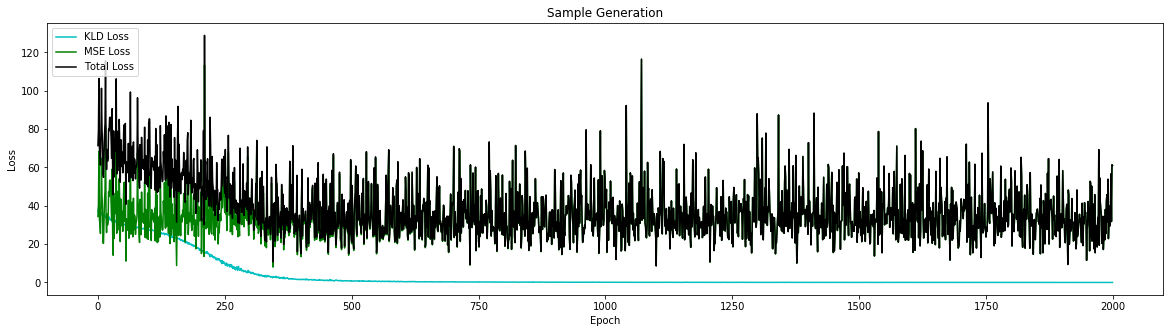

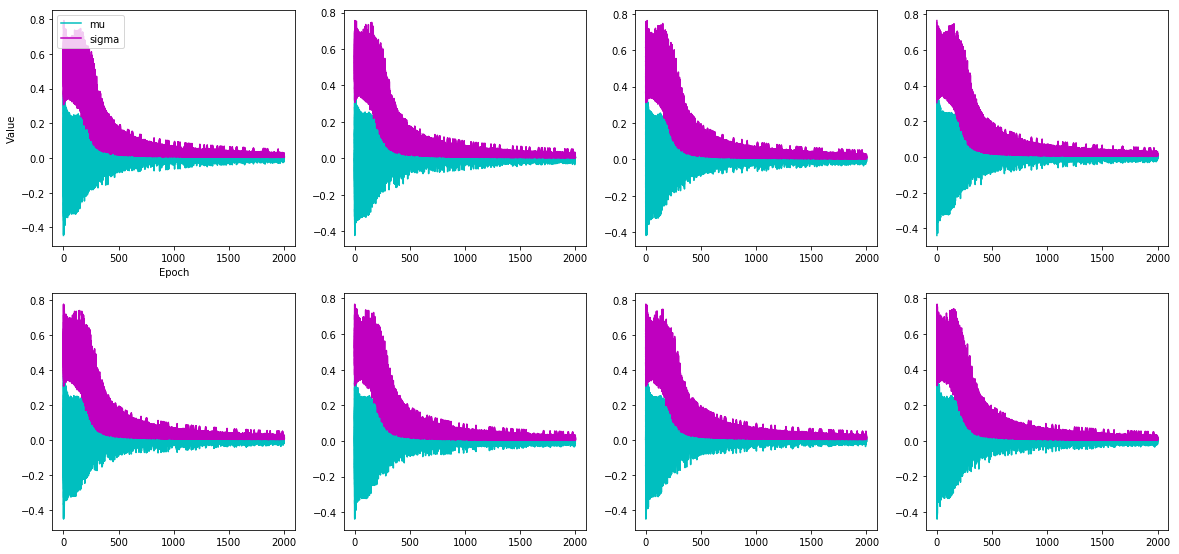

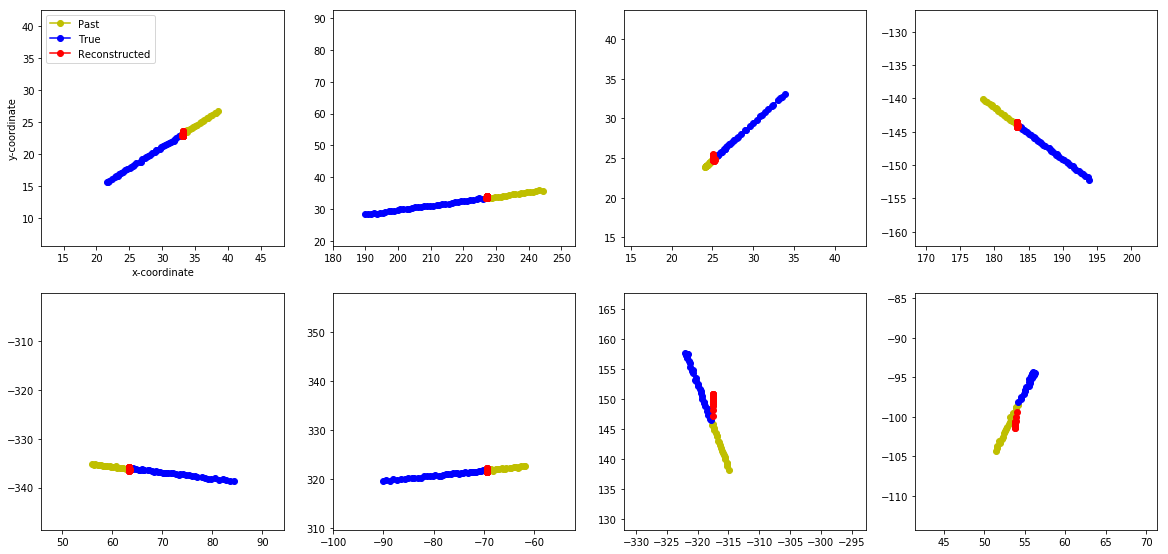

In [16]:
# Plot losses
loss_fig = plt.figure(figsize=(20, 5))
ax = loss_fig.add_subplot(1, 1, 1)
ax.plot(range(num_epochs), all_kld_loss, linestyle='-', color='c', label='KLD Loss')
ax.plot(range(num_epochs), all_mse_loss, linestyle='-', color='g', label='MSE Loss')
ax.plot(range(num_epochs), all_loss, linestyle='-', color='k', label='Total Loss')
ax.set_title('Sample Generation')
ax.legend(loc='upper left')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Plot mu and sigma
cvae_fig = plt.figure(figsize=(20, 20))
cvae_fig.tight_layout()
first_cvae_fig_ax = None
for i in range(batch_size):    
    ax = cvae_fig.add_subplot(batch_size/2, batch_size/2, i + 1)
    ax.plot(range(num_epochs), all_mu[i].cpu().detach().numpy(), linestyle='-', color='c', label='mu')
    ax.plot(range(num_epochs), all_sigma[i].cpu().detach().numpy(), linestyle='-', color='m', label='sigma')
        
    if i == 0:
        first_cvae_fig_ax = ax
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        
    if i == batch_size - 1:
        handles, labels = cvae_fig.gca().get_legend_handles_labels()
        j = 1
        while j < len(labels):
            if labels[j] in labels[:j]:
                del(labels[j])
                del(handles[j])
            else:
                j += 1
        first_cvae_fig_ax.legend(handles, labels, loc='upper left')

visualise_trajectories(last_X_true, last_Y_true, batch_size, Y_hats=[last_Y_hat])

## Test
<a id='sg_test'></a>

In [17]:
test_sample_generator = SampleGenerator(X_seq_len, Y_seq_len)
test_sample_generator.load_state_dict(torch.load(save_path))

<Figure size 1440x1440 with 0 Axes>

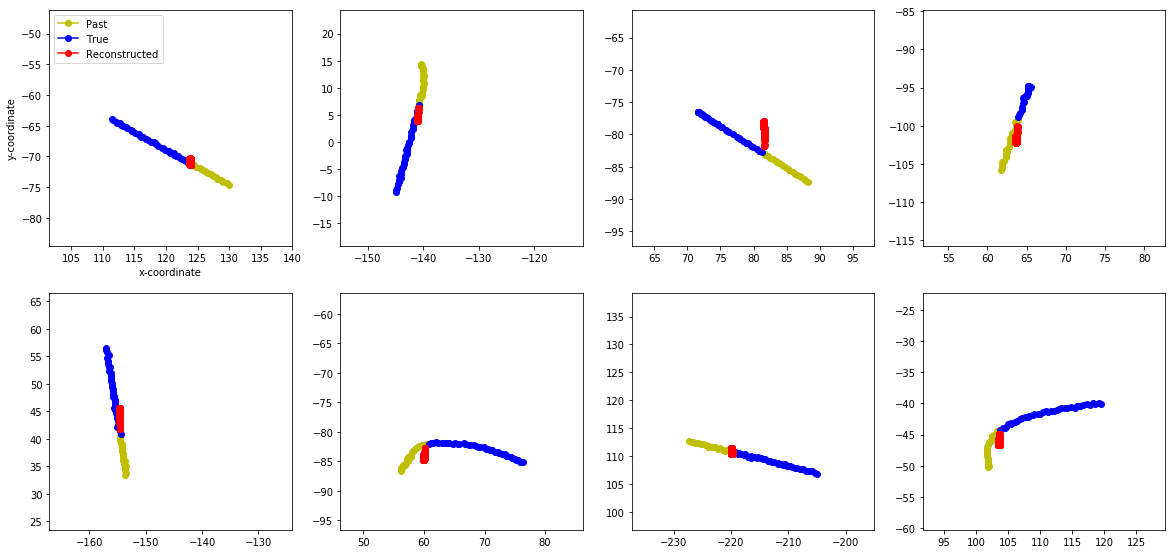

In [21]:
X_position, Y_position, X_displacement, Y_displacement = get_batch(X_seq_len, Y_seq_len, batch_size, data_dict,
                                                                   remove_stop=True,
                                                                   augment_noise=True,
                                                                   augment_rotate=True)
num_predictions = 10
Y_hats = []

# Generate list of random z
for i in range(num_predictions):
    z = torch.randn(batch_size, 48).cuda().unsqueeze(0)
    Y_hat = test_sample_generator([X_position, X_displacement],
                                       batch_size, flag='test', input_z=z)
    Y_hats.append(Y_hat.permute(1, 2, 0))

# Plot
traj_fig = plt.figure(figsize=(20, 20))
traj_fig.tight_layout()
X_true = X_position
Y_true = Y_position.permute(2, 0, 1).permute(1, 2, 0)

visualise_trajectories(X_true, Y_true, batch_size, Y_hats=Y_hats)

# Ranking & Refinement Module
<a id='rr_module'></a>